# Convolutional Conditional VAE on EMNIST
Data source: [The EMNIST Dataset](https://www.nist.gov/node/1298471/emnist-dataset)

EMNIST ByClass: 
* segmented digits and characters arranged by class
* 62 classes comprising [0-9], [a-z] and [A-Z]

## Import module and dataset

In [1]:
from keras.layers import Lambda,Input,Dense,Flatten,Conv2D,Conv2DTranspose
from keras.layers import Activation,BatchNormalization,Reshape,Concatenate,Dropout
from keras.models import Model
from keras.losses import mse, binary_crossentropy
from keras.callbacks import Callback,ModelCheckpoint,ReduceLROnPlateau
from keras.utils import to_categorical
from keras import backend as K
from keras.optimizers import Adam
from keras import initializers
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import cv2
from mnist import MNIST

Using TensorFlow backend.


In [2]:
emndata = MNIST('emnist_data')
img_rows = 28
img_cols = 28
img_channel = 1
orig_dimension = img_rows*img_cols

X_train,y_train = emndata.load('emnist_data/emnist-byclass-train-images-idx3-ubyte',
                               'emnist_data/emnist-byclass-train-labels-idx1-ubyte')
X_test,y_test = emndata.load('emnist_data/emnist-byclass-test-images-idx3-ubyte',
                             'emnist_data/emnist-byclass-test-labels-idx1-ubyte')
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)


print('X_train shape: {}'.format(X_train.shape))
print('X_test shape: {}'.format(X_test.shape))
print('y_train shape: {}'.format(y_train.shape))
print('y_test shape: {}'.format(y_test.shape))

X_train shape: (697932, 784)
X_test shape: (116323, 784)
y_train shape: (697932,)
y_test shape: (116323,)


In [3]:
label_str = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz'
lebel_dict = {i:v for i,v in enumerate(label_str)}

## Dataset samples

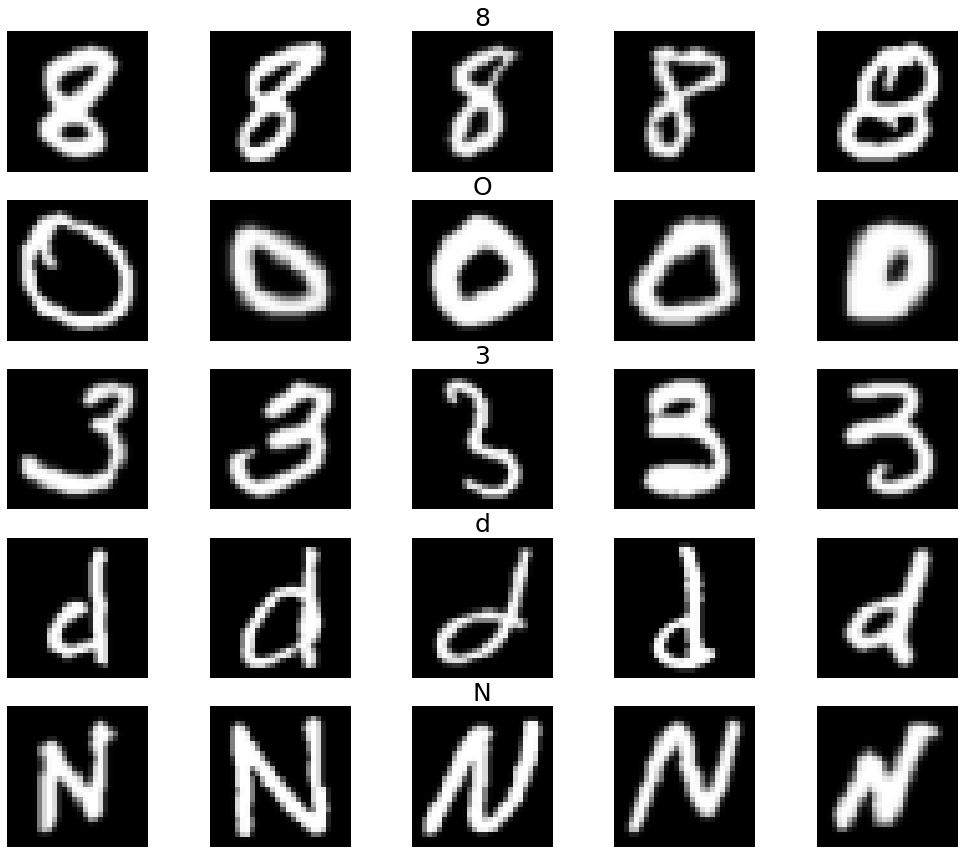

In [4]:
np.random.seed(100)
n_samples = 5
n_cls = 5
n_label = len(np.unique(y_train))
fig, rows = plt.subplots(n_cls,n_samples,figsize=(4*n_samples,3*n_cls))

for row,cls in zip(rows,np.random.choice(list(range(n_label)),n_cls)):
    row[int(np.floor(n_samples/2))].set_title(lebel_dict[cls],fontsize=25)
    for col_ax,img_idx in zip(row,[i for i,v in enumerate(y_train) if v==cls][:n_samples]):
        img = X_train[img_idx].reshape(img_rows,img_cols)
        img = np.transpose(img)
        col_ax.imshow(img,cmap='gray')
        col_ax.axis('off')
plt.subplots_adjust(left=0.2, wspace=0.02)

In [5]:
X_train = X_train.astype('float32')/(255/2)-1 # for tanh
X_test = X_test.astype('float32')/(255/2)-1
y_train = to_categorical(y_train,n_label)
y_test = to_categorical(y_test,n_label)
print('y_train shape: {}'.format(y_train.shape))
print('y_test shape: {}'.format(y_test.shape))

y_train shape: (697932, 62)
y_test shape: (116323, 62)


In [6]:
def sampling(arg):
    arg = [z_mean,z_log_var]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], dim),mean=0.0, stddev=1.0) # reparameterization trick
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [7]:
image_shape = (img_rows,img_cols,img_channel)
batch_size = 128
latent_dim = 10
epochs = 50

## Convolutional Conditional VAE - Encoder

In [8]:
w_init = initializers.random_normal(stddev=0.02)
gamma_init = initializers.random_normal(mean=1.0,stddev=0.02)

img_inputs = Input(shape=(orig_dimension,),name='image_input')
label_inputs = Input(shape=(n_label,),name='label_input')
encoder_inputs = Concatenate()([img_inputs,label_inputs])

x = Dense(orig_dimension,kernel_initializer=w_init,activation='relu')(encoder_inputs)

x = Reshape(image_shape)(x)
x = Conv2D(16,3,strides=1,padding='same',kernel_initializer=w_init)(x)
x = BatchNormalization(gamma_initializer=gamma_init)(x)
x = Activation('relu')(x)
x = Conv2D(32,3,strides=1,padding='same',kernel_initializer=w_init)(x)
x = BatchNormalization(gamma_initializer=gamma_init)(x)
x = Activation('relu')(x)
x = Conv2D(64,3,strides=2,padding='same',kernel_initializer=w_init)(x)
x = BatchNormalization(gamma_initializer=gamma_init)(x)
x = Activation('relu')(x)
before_flatten_shape = K.int_shape(x)
x = Flatten()(x)
x = Dense(128,kernel_initializer=w_init,activation='relu')(x)

z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

encoder = Model([img_inputs,label_inputs],[z_mean,z_log_var,z],name='encoder')
encoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_input (InputLayer)        (None, 784)          0                                            
__________________________________________________________________________________________________
label_input (InputLayer)        (None, 62)           0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 846)          0           image_input[0][0]                
                                                                 label_input[0][0]                
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 784)          664048      concatenate_1[0][0]              
__________

## Convolutional Conditional VAE - Decoder

In [9]:
latent_inputs = Input(shape=(latent_dim,),name='latent_inputs')
decoder_inputs = Concatenate()([latent_inputs,label_inputs])

x = Dense(128,kernel_initializer=w_init,activation='relu')(decoder_inputs)
x = Dense(before_flatten_shape[1]*before_flatten_shape[2]*before_flatten_shape[3],activation='relu',kernel_initializer=w_init)(x)
x = Reshape((before_flatten_shape[1],before_flatten_shape[2],before_flatten_shape[3]))(x)

x = Conv2DTranspose(64,3,strides=1,padding='same',kernel_initializer=w_init)(x)
x = BatchNormalization(gamma_initializer=gamma_init)(x)
x = Activation('relu')(x)

x = Conv2DTranspose(32,3,strides=2,padding='same',kernel_initializer=w_init)(x)
x = BatchNormalization(gamma_initializer=gamma_init)(x)
x = Activation('relu')(x)

x = Conv2DTranspose(16,3,strides=1,padding='same',kernel_initializer=w_init)(x)
x = BatchNormalization(gamma_initializer=gamma_init)(x)
x = Activation('relu')(x)

x = Conv2DTranspose(img_channel,3,activation='tanh',padding='same',kernel_initializer=w_init)(x)
outputs = Flatten()(x)

# instantiate decoder model
decoder = Model([latent_inputs,label_inputs],outputs,name='decoder')
decoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
latent_inputs (InputLayer)      (None, 10)           0                                            
__________________________________________________________________________________________________
label_input (InputLayer)        (None, 62)           0                                            
__________________________________________________________________________________________________
concatenate_2 (Concatenate)     (None, 72)           0           latent_inputs[0][0]              
                                                                 label_input[0][0]                
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 128)          9344        concatenate_2[0][0]              
__________

## Convolutional Conditional VAE - complete model

In [10]:
outputs = decoder([encoder([img_inputs,label_inputs])[2],label_inputs])
vae = Model([img_inputs,label_inputs], outputs)

In [11]:
beta = 1 # 1 --> regular VAE
reconstruction_loss = mse(img_inputs,outputs)
reconstruction_loss *= img_rows*img_cols

kl_loss = -0.5*beta*K.sum(1+z_log_var-K.square(z_mean)-K.exp(z_log_var),axis=-1)
vae_loss = K.mean(reconstruction_loss+kl_loss)

In [12]:
learning_rate = 0.001
vae.add_loss(vae_loss) ## in this case, we set y value to NONE during the fit
vae.compile(optimizer=Adam(lr=learning_rate))
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_input (InputLayer)        (None, 784)          0                                            
__________________________________________________________________________________________________
label_input (InputLayer)        (None, 62)           0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 10), (None,  2296132     image_input[0][0]                
                                                                 label_input[0][0]                
__________________________________________________________________________________________________
decoder (Model)                 (None, 784)          1688129     encoder[1][2]                    
          

## Callback functions

In [13]:
# class NEpochPrint(Callback):
#     def __init__(self, display_step):
#         self.epoch = 0
#         self.display_step = display_step
#     def on_epoch_end(self,epoch,logs={}):
#         self.epoch += 1        
#         if self.epoch == 1 or self.epoch % self.display_step == 0:
#             print('Epoch: {}/{} ..... {}: {:.4f} - {}: {:.4f}'.format(self.epoch,
#                                                                       self.params['epochs'],
#                                                                       self.params['metrics'][0], 
#                                                                       logs.get(self.params['metrics'][0]),
#                                                                       self.params['metrics'][1],               
#                                                                       logs.get(self.params['metrics'][1])))
# NEpochPrinter = NEpochPrint(display_step=2)

In [14]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',patience=5,verbose=1,factor=0.5,min_lr=0.00001)

saving_folder = 'best_weight_ldg_v2_conv-cvae'
file_name = 'ldg_v2_conv-cvae'
os.makedirs(saving_folder,exist_ok=True)
best_model_weight_path = os.path.join(saving_folder,file_name+'-best-wiehgts'+'-{epoch:03d}-{loss:.3f}-{val_loss:.3f}.h5')
save_best_model = ModelCheckpoint(best_model_weight_path,monitor='val_loss',verbose=0,save_weights_only=True,save_best_only=True,mode='min')
def train_or_load_weights(flag,weight_name=None):
    if flag == 'train':
        hist = vae.fit([X_train,y_train],
                       epochs=epochs,
                       batch_size=batch_size,
                       validation_data=([X_test,y_test],None),
                       verbose=1,
                       callbacks=[save_best_model,learning_rate_reduction])#,NEpochPrinter])
        return hist
    if flag == 'load':
        vae.load_weights(os.path.join(saving_folder,weight_name)) # load all the weights for encoder and decoder when loading for vae

## Training

In [15]:
hist = train_or_load_weights(flag='train')

Train on 697932 samples, validate on 116323 samples
Epoch 1/50
697932/697932 [==============================] - 204s 292us/step - loss: 163.5012 - val_loss: 153.0424
Epoch 2/50
697932/697932 [==============================] - 201s 289us/step - loss: 151.9185 - val_loss: 151.1725
Epoch 3/50
697932/697932 [==============================] - 201s 289us/step - loss: 148.9970 - val_loss: 150.0969
Epoch 4/50
697932/697932 [==============================] - 201s 288us/step - loss: 147.1227 - val_loss: 146.8538
Epoch 5/50
697932/697932 [==============================] - 201s 289us/step - loss: 145.7672 - val_loss: 145.2493
Epoch 6/50
697932/697932 [==============================] - 201s 288us/step - loss: 144.6946 - val_loss: 145.5242
Epoch 7/50
697932/697932 [==============================] - 201s 288us/step - loss: 144.1407 - val_loss: 147.4587
Epoch 8/50
697932/697932 [==============================] - 201s 288us/step - loss: 143.1727 - val_loss: 142.0870
Epoch 9/50
697932/697932 [==========

In [16]:
def training_plot(hist,model_name):
    loss = [hist.history['loss'],hist.history['val_loss']]
    plt.plot(loss[0],color='b',label='training')
    plt.plot(loss[1],color='r',label='valid')
    plt.title(model_name,fontsize=18)
    plt.legend(loc='best',fontsize=13)
    plt.xlabel('epoch',fontsize=15)
    plt.ylabel('loss',fontsize=15)
    plt.tick_params(axis='both',labelsize=13)

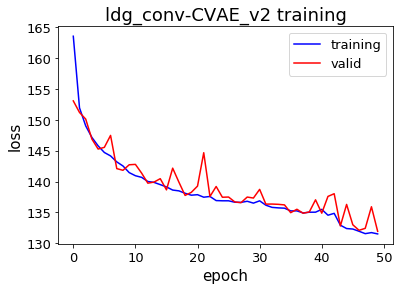

In [17]:
training_plot(hist,'ldg_conv-CVAE_v2 training')

In [18]:
def plot_five_reconstruction(input_set,label_set,random_idx,encoder,decoder):
    fig, axes = plt.subplots(2,5,figsize=(15,5))
    for row,flag in zip(axes,['in_img','out_img']): 
        for col,idx in zip(row,random_idx):
            original = input_set[idx]
            if flag == 'in_img':
                original_img = original.reshape(img_rows,img_cols)
                original_img = np.transpose(original_img)
                col.imshow(1-original_img,cmap='bone')
                col.set_title('idx = {}\nlabel = {}\noriginal'.format(idx,lebel_dict[np.argmax(label_set[idx])]))
            if flag == 'out_img':
                encoded_z = encoder.predict([np.expand_dims(original,0),np.expand_dims(label_set[idx],0)],batch_size=1)[2]
                predict = decoder.predict([encoded_z,np.expand_dims(label_set[idx],0)])
                predict = (0.5*predict) + 0.5 # image back to 0-1 from -1 - 1
                decoded = predict.reshape(img_rows,img_cols)
                decoded = np.transpose(decoded)
                col.imshow(1-decoded,cmap='bone')
                col.set_title('reconstructed')
            col.axis('off')

## Traing set reconstruction

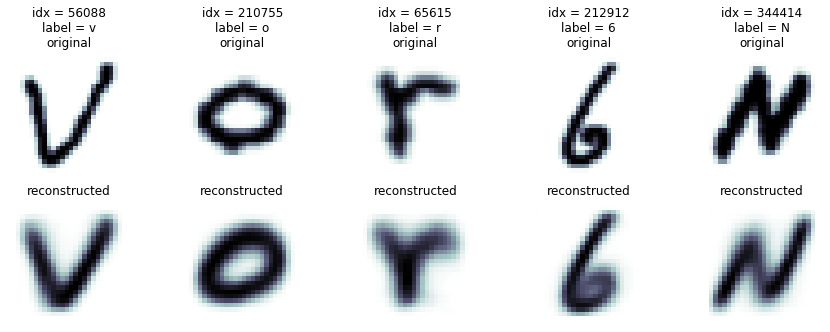

In [19]:
np.random.seed(100)
random_idx = np.random.randint(len(X_train),size=5)
plot_five_reconstruction(X_train,y_train,random_idx,encoder,decoder)

## Test set reconstruction

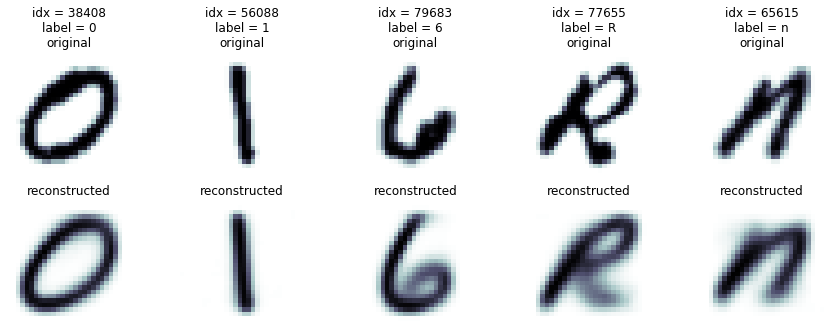

In [20]:
np.random.seed(100)
random_idx = np.random.randint(len(X_test),size=5)
plot_five_reconstruction(X_test,y_test,random_idx,encoder,decoder)

## Generating arbitrary handwritten letters/digits

In [21]:
def find_idx_from_label_dict(search_str):
    for i,val in lebel_dict.items():
        if val == search_str:
            return i    
def letter_digit_gen(input_str,th=None):
    gap = 20
    img = np.zeros((img_cols,gap*len(input_str)+(img_cols-gap)))
    for idx,l in enumerate(input_str):
        if l == ' ':
            img[:,gap*idx:gap*idx+img_cols] += np.zeros((img_cols,img_cols))
        elif l not in label_str:
            pass
        else:
            cls_idx = find_idx_from_label_dict(l)
            latent = np.random.randn(latent_dim)
            latent = np.expand_dims(np.random.randn(latent_dim),0)
            generated = decoder.predict([latent,np.expand_dims(to_categorical(cls_idx,n_label),0)])
            generated = (0.5*generated) + 0.5
            generated = generated.reshape(img_rows,img_cols)
            generated = np.transpose(generated)
            img[:,gap*idx:gap*idx+img_cols] += generated 
    if th != None:
        for i,v in np.ndenumerate(img):
            if v >= th:
                img[i] = 1
            else:
                img[i] = 0
    return img        

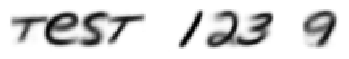

In [22]:
img = letter_digit_gen('TesT 123?9')
plt.imshow(1-img,cmap='gray')
plt.axis('off')
plt.show()

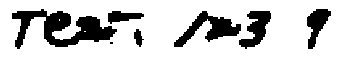

In [23]:
img = letter_digit_gen('TesT 123?9',th=0.2)
plt.imshow(1-img,cmap='gray')
plt.axis('off')
plt.show()

In [24]:
def sample_images_gen(input_str,rows=5,cols=3,th=None):
    images = []
    for _ in range(rows):
        current = []
        for _ in range(cols):
            current.append(letter_digit_gen(input_str,th=th))
            current.append(np.ones(shape=(img_rows,10)))
        images.append(np.concatenate(current, axis=1))
    combined_img = np.concatenate(images)
    plt.figure(figsize=(15,20))
    plt.imshow(1-combined_img,cmap='gray')
    plt.axis('off')

In [25]:
sample_text = 'HeLlo 2?468'

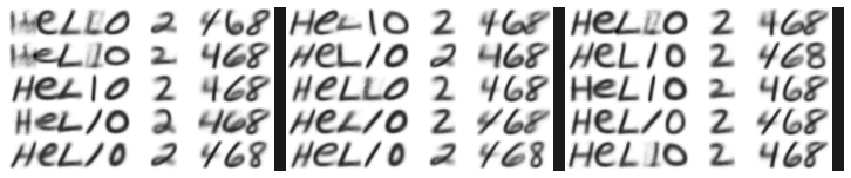

In [26]:
sample_images_gen(sample_text)

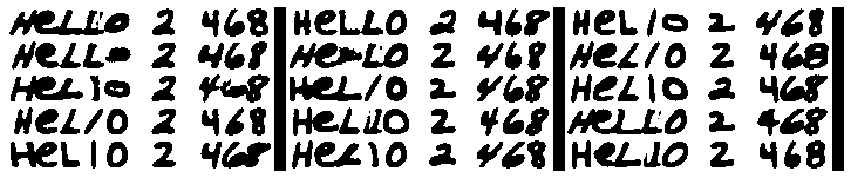

In [27]:
sample_images_gen(sample_text,th=0.2)